In [21]:
#%run ../Exploring_data/Exploratory_analysis.ipynb

# First we are consider it as a regression problem:

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

In [23]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

In [24]:
df.columns

Index(['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)',
       'Demanda_programada_P48_total', 'Precio_mercado_SPOT_Diario',
       'Precio_mercado_SPOT_Intradiario_Sesion_1',
       'Precio_mercado_SPOT_Intradiario_Sesion_2',
       'Demanda_programada_P48_Correccion_eolica',
       'Demanda_programada_P48_Correccion_solar',
       'Generacion_programada_P48_Biogas', 'Generacion_programada_P48_Biomasa',
       'Generacion_programada_P48_Ciclo_combinado',
       'Generacion_programada_P48_Consumo_bombeo',
       'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
       'Generacion_programada_P48_Energia_residual',
       'Generacion_programada_P48_Enlace_Baleares',
       'Generacion_programada_P48_Eolica_terrestre',
       'Generacion_programada_P48_Gas_Natural',
       'Generacion_programada_P48_Gas_Natural_Cogeneracion',
       'Generacion_programada_P48_Hidraulica_UGH',
       'Generacion_programada_P48_Hidraulica_no_UGH',
       'Generacio

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column 7 days so, with the information we have today, we can predict the value for the electricity in 7 days:

In [25]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original columns (you don't need them anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [26]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)

In [27]:
df.dropna(axis=0,how='any',inplace=True)

In [28]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 'Consumer_price_index', 
                 'Time_required_to_get_electricity_(days)',
                 'Inflation,consumer_prices_(annual_%)',
                 'Employment_in_industry_(%_of_total_employment)', 
                 'PIB_Trimestral', 
                 'Var_Trim_PIB_(%)', 
                 'Var_anual_PIB_Trim_(%)',
                 'IBEX35',
                 'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

In [29]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_train_aux, X_test, y_train_aux, y_test = train_test_split(X, y, train_size=0.8,test_size=0.2, random_state=101)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_aux, y_train_aux, train_size=0.8,test_size=0.2, random_state=101)

In [30]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)

parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}

xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

In [31]:
%%time
xgb_mod.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  6.0min finished


CPU times: user 47.4 s, sys: 1.38 s, total: 48.8 s
Wall time: 6min 2s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    early_stopping_rounds=15, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, m...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_job

In [32]:
eval_set = [(X_train, y_train), (X_validation, y_validation)]

xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:79.65031	validation_0-mae:73.02198	validation_1-rmse:80.30316	validation_1-mae:73.63796
[1]	validation_0-rmse:64.04524	validation_0-mae:58.45878	validation_1-rmse:64.62420	validation_1-mae:58.98465
[2]	validation_0-rmse:52.08713	validation_0-mae:46.87199	validation_1-rmse:52.69246	validation_1-mae:47.40032
[3]	validation_0-rmse:42.94536	validation_0-mae:37.71214	validation_1-rmse:43.57449	validation_1-mae:38.23597
[4]	validation_0-rmse:34.78215	validation_0-mae:30.35749	validation_1-rmse:35.34722	validation_1-mae:30.82126
[5]	validation_0-rmse:29.11296	validation_0-mae:24.68904	validation_1-rmse:29.70415	validation_1-mae:25.20088
[6]	validation_0-rmse:23.86315	validation_0-mae:20.11483	validation_1-rmse:24.41772	validation_1-mae:20.59346
[7]	validation_0-rmse:20.39894	validation_0-mae:16.80107	validation_1-rmse:21.00141	validation_1-mae:17.30628
[8]	validation_0-rmse:17.31265	validation_0-mae:14.12115	validation_1-rmse:17.89529	validation_1-mae:14.59295
[9]	valida

[77]	validation_0-rmse:4.79554	validation_0-mae:3.63410	validation_1-rmse:6.16225	validation_1-mae:4.62993
[78]	validation_0-rmse:4.76437	validation_0-mae:3.61037	validation_1-rmse:6.14270	validation_1-mae:4.61357
[79]	validation_0-rmse:4.73626	validation_0-mae:3.58799	validation_1-rmse:6.12445	validation_1-mae:4.59965
[80]	validation_0-rmse:4.69643	validation_0-mae:3.55953	validation_1-rmse:6.09352	validation_1-mae:4.57872
[81]	validation_0-rmse:4.68235	validation_0-mae:3.54826	validation_1-rmse:6.08432	validation_1-mae:4.57030
[82]	validation_0-rmse:4.65280	validation_0-mae:3.52643	validation_1-rmse:6.06175	validation_1-mae:4.55485
[83]	validation_0-rmse:4.63180	validation_0-mae:3.50994	validation_1-rmse:6.04405	validation_1-mae:4.54302
[84]	validation_0-rmse:4.61922	validation_0-mae:3.50000	validation_1-rmse:6.03690	validation_1-mae:4.53661
[85]	validation_0-rmse:4.59264	validation_0-mae:3.48065	validation_1-rmse:6.01521	validation_1-mae:4.52318
[86]	validation_0-rmse:4.57032	valida

[154]	validation_0-rmse:3.53942	validation_0-mae:2.67963	validation_1-rmse:5.33061	validation_1-mae:4.00726
[155]	validation_0-rmse:3.53111	validation_0-mae:2.67258	validation_1-rmse:5.32787	validation_1-mae:4.00364
[156]	validation_0-rmse:3.51513	validation_0-mae:2.66083	validation_1-rmse:5.32136	validation_1-mae:3.99812
[157]	validation_0-rmse:3.49853	validation_0-mae:2.64858	validation_1-rmse:5.31086	validation_1-mae:3.99051
[158]	validation_0-rmse:3.48790	validation_0-mae:2.63989	validation_1-rmse:5.30791	validation_1-mae:3.98747
[159]	validation_0-rmse:3.47761	validation_0-mae:2.63199	validation_1-rmse:5.30214	validation_1-mae:3.98269
[160]	validation_0-rmse:3.46592	validation_0-mae:2.62296	validation_1-rmse:5.29366	validation_1-mae:3.97687
[161]	validation_0-rmse:3.45746	validation_0-mae:2.61582	validation_1-rmse:5.28951	validation_1-mae:3.97309
[162]	validation_0-rmse:3.44583	validation_0-mae:2.60677	validation_1-rmse:5.28425	validation_1-mae:3.96846
[163]	validation_0-rmse:3.43

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, early_stopping_rounds=15,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.2, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [33]:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

,Demanda_programada_P48_total,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Generacion_programada_P48_Biogas,Generacion_programada_P48_Biomasa,Generacion_programada_P48_Ciclo_combinado,Generacion_programada_P48_Consumo_bombeo,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,0.017704,0.000381,0.004128,0.027011,0.019627,0.004608,0.000669,0.000604,0.00061,0.000718,...,0.000727,0.000618,0.00085,0.001284,0.00193,0.001476,0.000817,0.000437,0.000701,0.000454


In [34]:
np.sqrt(abs(xgb_mod.best_score_))

5.280751962624455

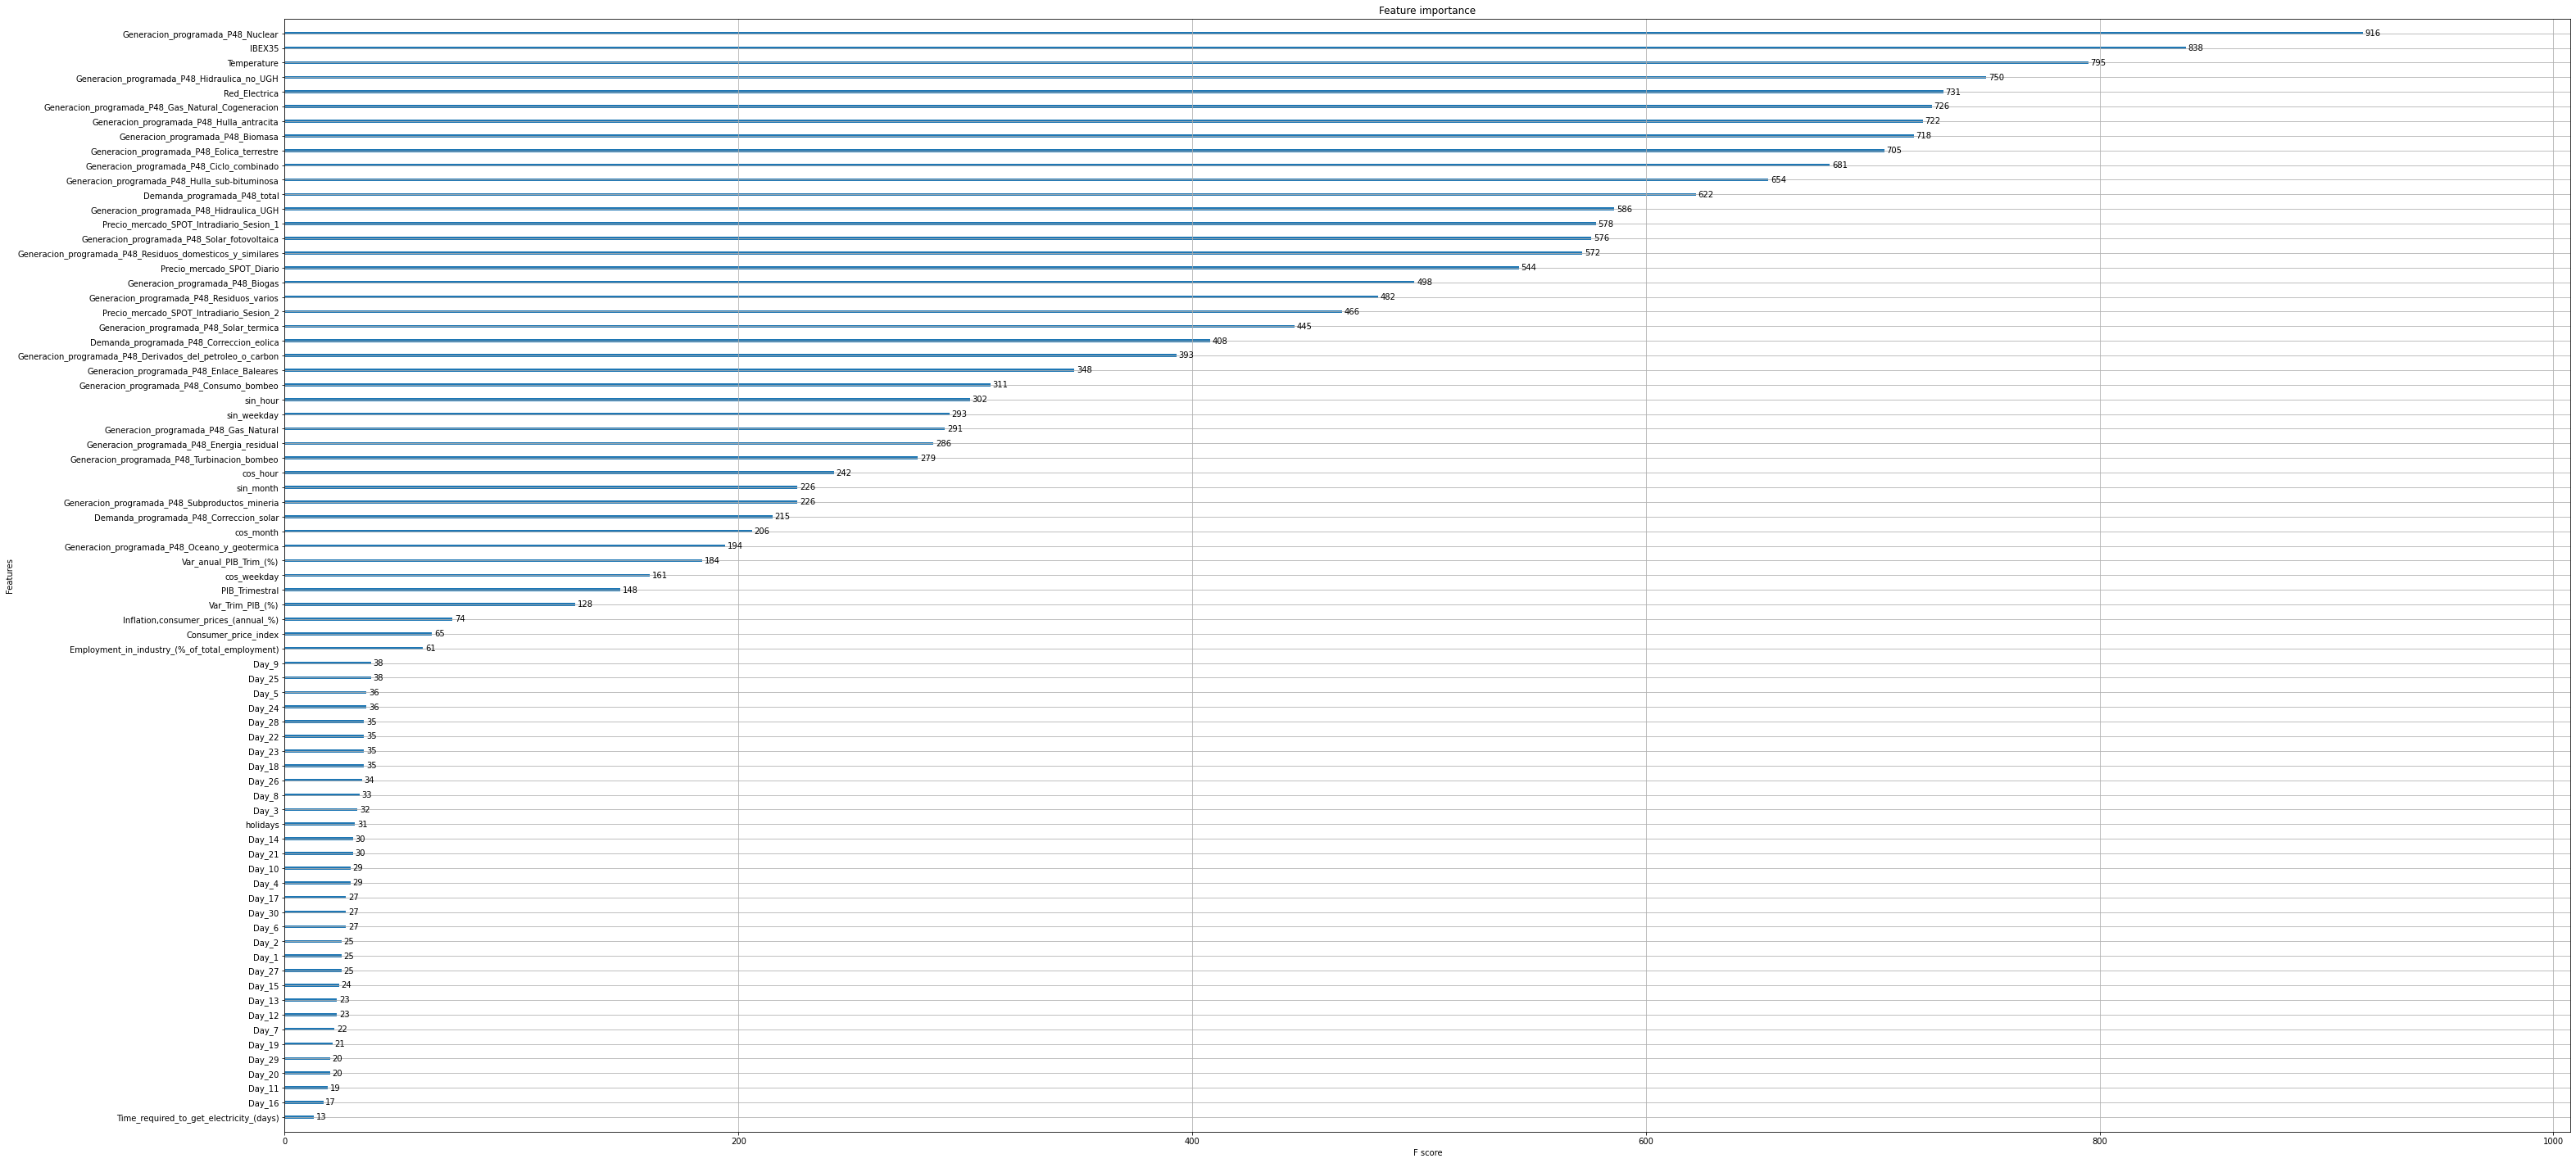

In [35]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [36]:
y_pred = xgb_mod.best_estimator_.predict(X_test) 

In [37]:
np.sqrt(mean_squared_error(y_test, y_pred))

4.9342318097202655

In [38]:
r2_score(y_test, y_pred)

0.9839133294666182

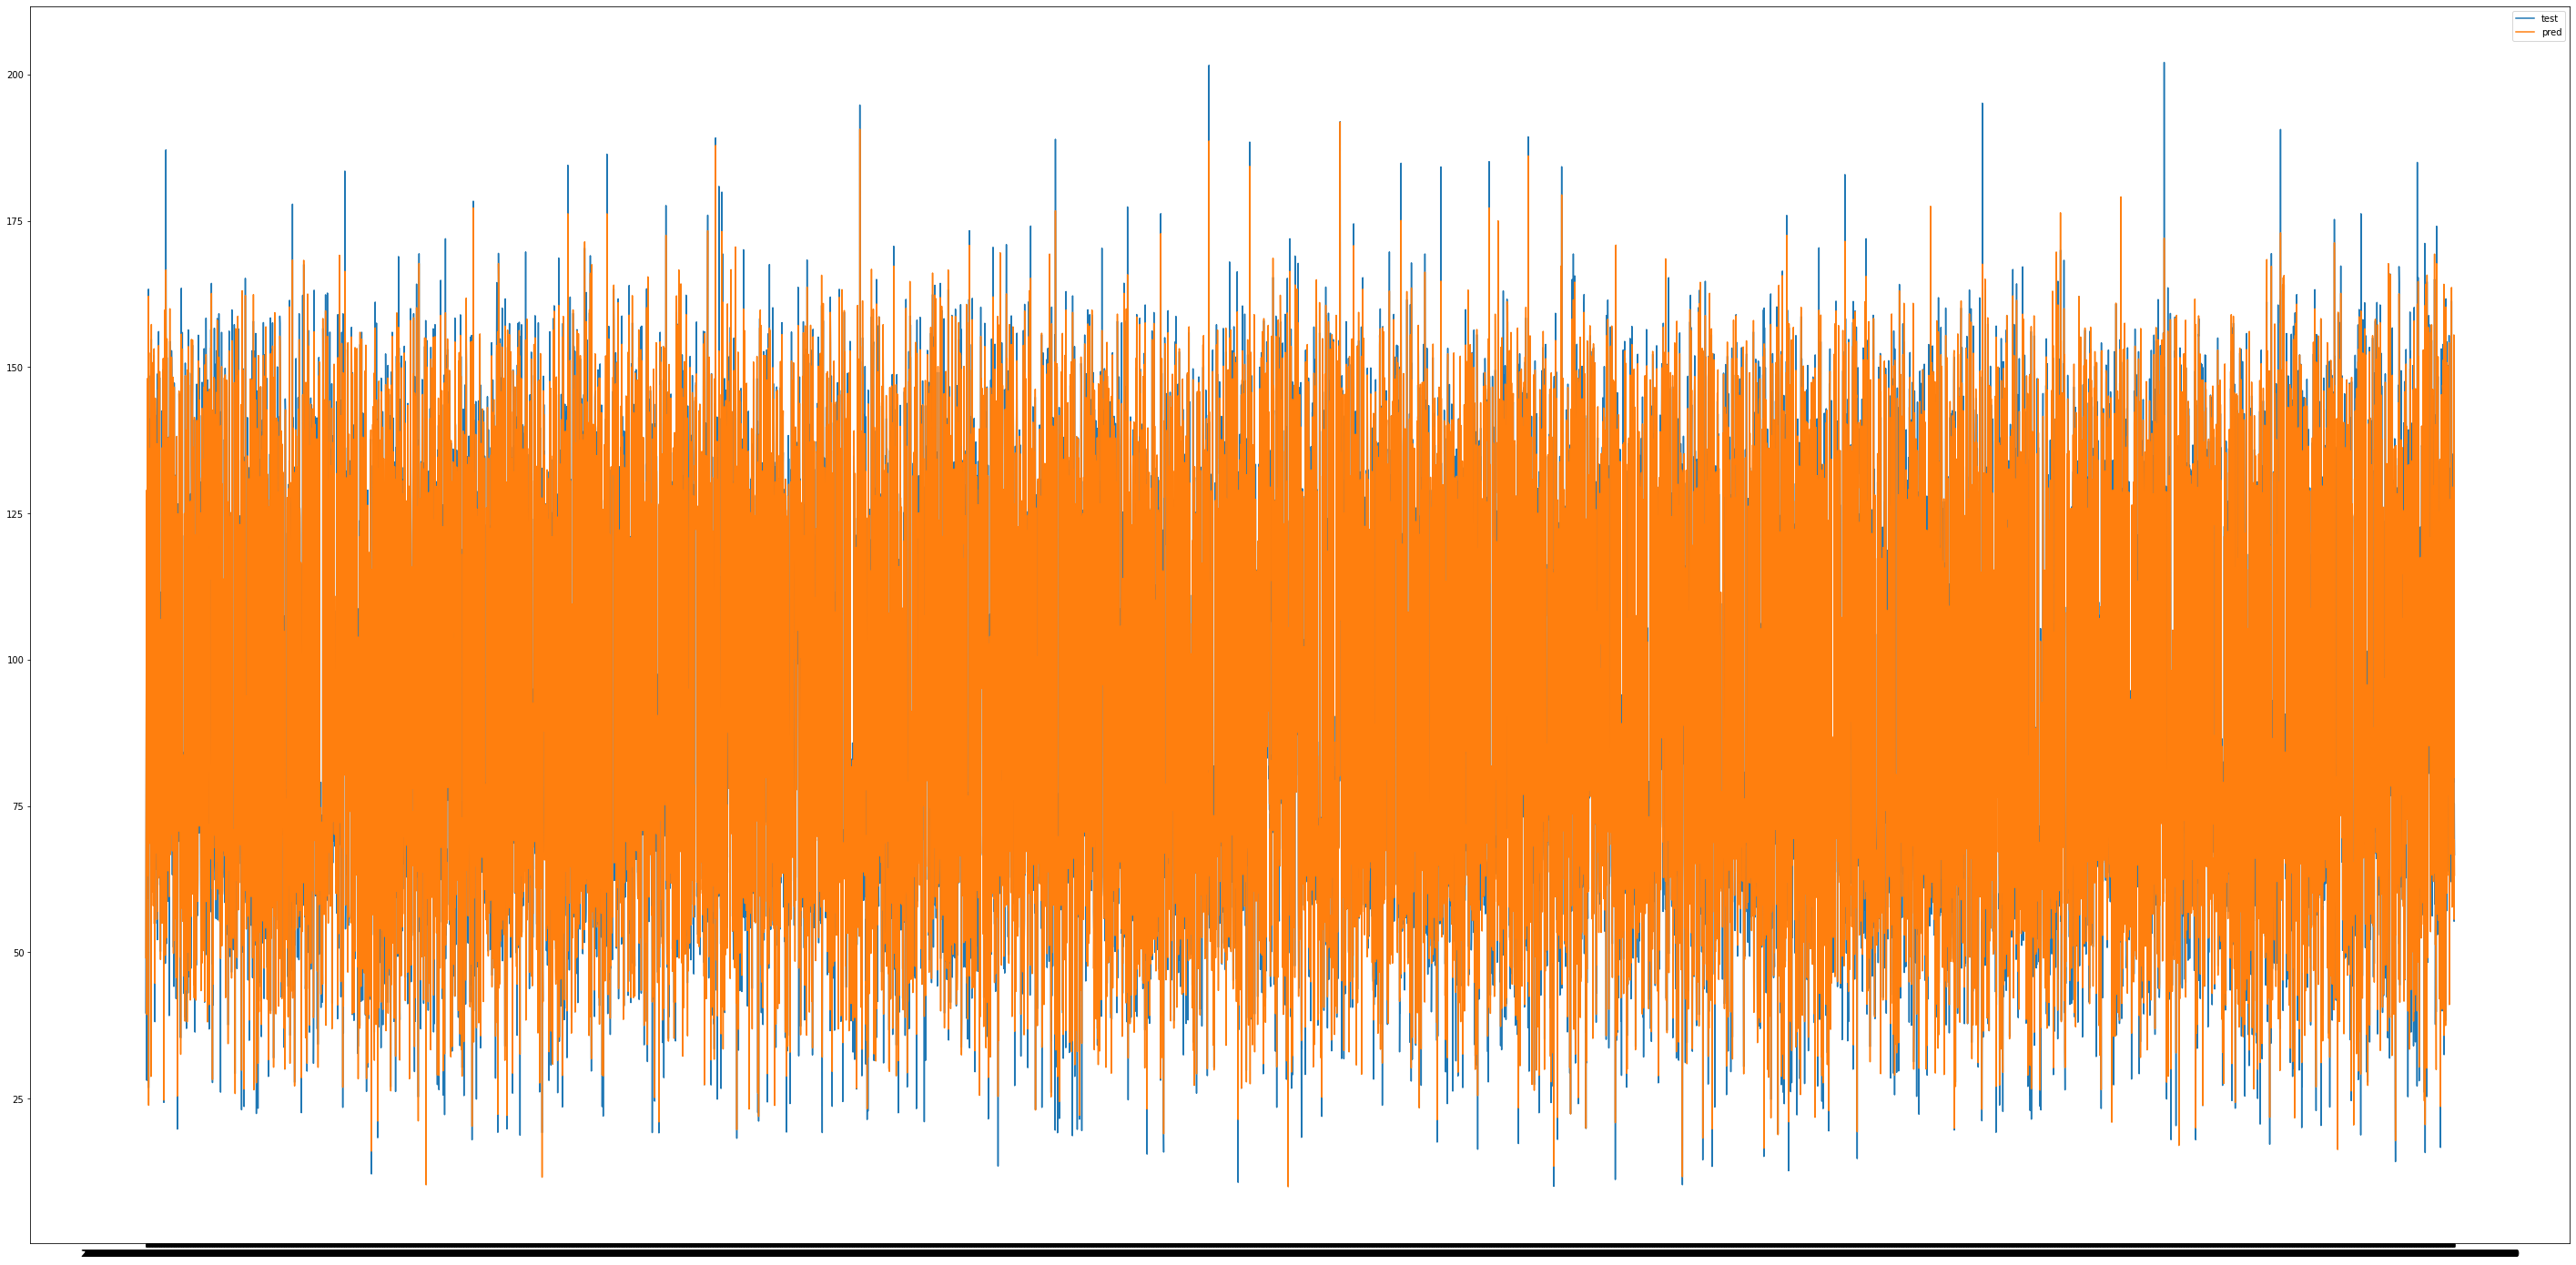

In [39]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

In [40]:
pd.DataFrame({'y_test':y_test, 'y_pred':y_pred},index = y_test.index).to_csv('./../Visualization/Xgboost.csv')

# If we consider it as a time series problem:

In [41]:
df = pd.read_csv('./final_dataframe.csv',index_col='datetime')

It is important to considerate the time that we want to predict. If we want to know the price for 1 week, we will need to shift the target column 7 days so, with the information we have today, we can predict the value for the electricity in 7 days:

In [42]:
df = pd.concat([df,pd.get_dummies(df['Weekday'], prefix='Weekday')],axis=1)
df = pd.concat([df,pd.get_dummies(df['Hour'], prefix='Hour')],axis=1)
df = pd.concat([df,pd.get_dummies(df['day'], prefix='Day')],axis=1)
df = pd.concat([df,pd.get_dummies(df['month'], prefix='Month')],axis=1)
df = pd.concat([df,pd.get_dummies(df['year'], prefix='Year')],axis=1)
# now drop the original columns (you don't need them anymore)
df.drop(['Weekday','Hour','day','month','year'],axis=1, inplace=True)

In [43]:
#Queremos adivinarlo con 7 días de antelacion: 7x24 = 168
df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']=df['Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)'].shift(-168)

In [44]:
df.dropna(axis=0,how='any',inplace=True)

In [45]:
model_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 #'Consumer_price_index', 
                 #'Time_required_to_get_electricity_(days)',
                 #'Inflation,consumer_prices_(annual_%)',
                 #'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature',
                 #'Weekday_Monday','Weekday_Tuesday', 'Weekday_Wednesday','Weekday_Thursday',
                 #'Weekday_Friday', 'Weekday_Saturday', 
                 'sin_weekday','cos_weekday',
                 'holidays', 
                 #'Hour_0', 'Hour_1', 'Hour_2',
                 #'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8', 'Hour_9',
                 #'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14', 'Hour_15',
                 #'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20', 'Hour_21',
                 #'Hour_22',
                 'sin_hour','cos_hour','sin_month','cos_month',
                 #'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6',
                 #'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11',
                 'Day_1', 'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Day_7', 'Day_8',
                 'Day_9', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
                 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_22',
                 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29',
                 'Day_30']

standarized_columns = ['Demanda_programada_P48_total', 
                 'Demanda_programada_P48_Correccion_eolica',
                 'Demanda_programada_P48_Correccion_solar',
                 'Precio_mercado_SPOT_Diario',
                 'Precio_mercado_SPOT_Intradiario_Sesion_1',
                 'Precio_mercado_SPOT_Intradiario_Sesion_2',
                 'Generacion_programada_P48_Biogas',
                 'Generacion_programada_P48_Biomasa',
                 'Generacion_programada_P48_Ciclo_combinado',
                 'Generacion_programada_P48_Consumo_bombeo',
                 'Generacion_programada_P48_Derivados_del_petroleo_o_carbon',
                 'Generacion_programada_P48_Energia_residual',
                 'Generacion_programada_P48_Enlace_Baleares',
                 'Generacion_programada_P48_Eolica_terrestre',
                 'Generacion_programada_P48_Gas_Natural',
                 'Generacion_programada_P48_Gas_Natural_Cogeneracion',
                 'Generacion_programada_P48_Hidraulica_UGH',
                 'Generacion_programada_P48_Hidraulica_no_UGH',
                 'Generacion_programada_P48_Hulla_antracita',
                 'Generacion_programada_P48_Hulla_sub-bituminosa',
                 'Generacion_programada_P48_Nuclear',
                 'Generacion_programada_P48_Oceano_y_geotermica',
                 'Generacion_programada_P48_Residuos_domesticos_y_similares',
                 'Generacion_programada_P48_Residuos_varios',
                 'Generacion_programada_P48_Solar_fotovoltaica',
                 'Generacion_programada_P48_Solar_termica',
                 'Generacion_programada_P48_Subproductos_mineria',
                 'Generacion_programada_P48_Turbinacion_bombeo',
                 #'Consumer_price_index', 
                 #'Time_required_to_get_electricity_(days)',
                 #'Inflation,consumer_prices_(annual_%)',
                 #'Employment_in_industry_(%_of_total_employment)', 
                 #'PIB_Trimestral', 
                 #'Var_Trim_PIB_(%)', 
                 #'Var_anual_PIB_Trim_(%)',
                 #'IBEX35',
                 #'Red_Electrica',
                 'Temperature']

In [46]:
X = df.loc[:,model_columns]
y = df.loc[:,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X[standarized_columns]) 

X[standarized_columns] = scaled_data

y_train = df.loc[:'2018-06-01 00:00:00+00:00','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_train = df.loc[:'2018-06-01 00:00:00+00:00',model_columns]
y_validation = df.loc['2018-06-01 00:00:00+00:00':'2019-06-01 00:00:00+00:00','Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_validation = df.loc['2018-06-01 00:00:00+00:00':'2019-06-01 00:00:00+00:00',model_columns]
y_test = df.loc['2019-06-01 00:00:00+00:00':,'Termino_de_facturacion_de_energia_activa_del_PVPC_eficiencia_2_periodos_(DHA)']
X_test = df.loc['2019-06-01 00:00:00+00:00':,model_columns]

In [47]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 20, n_estimators = 200, early_stopping_rounds = 15)

parameters = {'colsample_bytree':[0.4,0.3],'learning_rate': [0.1,0.15,0.2],
                'max_depth': [5,7,9]}

xgb_mod = GridSearchCV(xg_reg,cv=5,verbose=1,param_grid=parameters,
                       scoring='neg_mean_squared_error',n_jobs=-1, error_score='raise')

In [48]:
%%time
xgb_mod.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  5.4min finished


CPU times: user 29.2 s, sys: 703 ms, total: 29.9 s
Wall time: 5min 26s


GridSearchCV(cv=5, error_score='raise',
             estimator=XGBRegressor(alpha=20, base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.3,
                                    early_stopping_rounds=15, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=0.1, max_delta_step=None,
                                    max_depth=5, min_child_weight=None,
                                    missing=nan, m...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=False, verbosity=None),
             iid='warn', n_job

In [49]:
eval_set = [(X_train, y_train), (X_validation, y_validation)]

xgb_mod.best_estimator_.fit(X_train,y_train,eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:85.89965	validation_0-mae:78.92173	validation_1-rmse:92.98681	validation_1-mae:87.76032
[1]	validation_0-rmse:74.30937	validation_0-mae:67.10157	validation_1-rmse:79.85881	validation_1-mae:74.27754
[2]	validation_0-rmse:64.09996	validation_0-mae:57.09832	validation_1-rmse:69.05833	validation_1-mae:63.65272
[3]	validation_0-rmse:54.81628	validation_0-mae:48.62019	validation_1-rmse:59.05026	validation_1-mae:54.44544
[4]	validation_0-rmse:46.93662	validation_0-mae:41.45323	validation_1-rmse:50.51124	validation_1-mae:46.54071
[5]	validation_0-rmse:40.89112	validation_0-mae:35.46910	validation_1-rmse:44.17426	validation_1-mae:40.19011
[6]	validation_0-rmse:35.83085	validation_0-mae:30.49260	validation_1-rmse:38.63446	validation_1-mae:34.57078
[7]	validation_0-rmse:31.72872	validation_0-mae:26.44653	validation_1-rmse:33.98814	validation_1-mae:29.79214
[8]	validation_0-rmse:28.31531	validation_0-mae:23.22780	validation_1-rmse:30.01416	validation_1-mae:25.80741
[9]	valida

[76]	validation_0-rmse:7.56015	validation_0-mae:5.73211	validation_1-rmse:8.81382	validation_1-mae:6.96053
[77]	validation_0-rmse:7.54749	validation_0-mae:5.72322	validation_1-rmse:8.81614	validation_1-mae:6.96565
[78]	validation_0-rmse:7.52095	validation_0-mae:5.70238	validation_1-rmse:8.81599	validation_1-mae:6.96246
[79]	validation_0-rmse:7.48346	validation_0-mae:5.68112	validation_1-rmse:8.81396	validation_1-mae:6.96028
[80]	validation_0-rmse:7.44601	validation_0-mae:5.65294	validation_1-rmse:8.81480	validation_1-mae:6.96103
[81]	validation_0-rmse:7.42403	validation_0-mae:5.63473	validation_1-rmse:8.81387	validation_1-mae:6.96168
[82]	validation_0-rmse:7.39655	validation_0-mae:5.61703	validation_1-rmse:8.82663	validation_1-mae:6.97581
[83]	validation_0-rmse:7.37816	validation_0-mae:5.60290	validation_1-rmse:8.84499	validation_1-mae:6.99242
[84]	validation_0-rmse:7.35221	validation_0-mae:5.58180	validation_1-rmse:8.86762	validation_1-mae:7.01232
[85]	validation_0-rmse:7.32580	valida

[153]	validation_0-rmse:6.24057	validation_0-mae:4.73682	validation_1-rmse:9.28840	validation_1-mae:7.45459
[154]	validation_0-rmse:6.22108	validation_0-mae:4.72391	validation_1-rmse:9.27709	validation_1-mae:7.44615
[155]	validation_0-rmse:6.21568	validation_0-mae:4.71964	validation_1-rmse:9.28424	validation_1-mae:7.45149
[156]	validation_0-rmse:6.20449	validation_0-mae:4.71053	validation_1-rmse:9.28692	validation_1-mae:7.45429
[157]	validation_0-rmse:6.18911	validation_0-mae:4.69866	validation_1-rmse:9.29785	validation_1-mae:7.46164
[158]	validation_0-rmse:6.17678	validation_0-mae:4.68924	validation_1-rmse:9.29458	validation_1-mae:7.45904
[159]	validation_0-rmse:6.15268	validation_0-mae:4.67187	validation_1-rmse:9.29538	validation_1-mae:7.46008
[160]	validation_0-rmse:6.14670	validation_0-mae:4.66688	validation_1-rmse:9.29695	validation_1-mae:7.46141
[161]	validation_0-rmse:6.12028	validation_0-mae:4.64942	validation_1-rmse:9.33720	validation_1-mae:7.50251
[162]	validation_0-rmse:6.10

XGBRegressor(alpha=20, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, early_stopping_rounds=15,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints=None, learning_rate=0.15, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=200, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [50]:
pd.DataFrame(xgb_mod.best_estimator_.feature_importances_.reshape(1, -1), columns=X.columns)

,Demanda_programada_P48_total,Demanda_programada_P48_Correccion_eolica,Demanda_programada_P48_Correccion_solar,Precio_mercado_SPOT_Diario,Precio_mercado_SPOT_Intradiario_Sesion_1,Precio_mercado_SPOT_Intradiario_Sesion_2,Generacion_programada_P48_Biogas,Generacion_programada_P48_Biomasa,Generacion_programada_P48_Ciclo_combinado,Generacion_programada_P48_Consumo_bombeo,...,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
0,0.031465,0.001079,0.015175,0.040244,0.02652,0.010211,0.001687,0.001419,0.000956,0.019529,...,0.001267,0.00093,0.002006,0.001611,0.002919,0.001277,0.001343,0.0009,0.001052,0.000693


In [51]:
np.sqrt(abs(xgb_mod.best_score_))

12.969851835368441

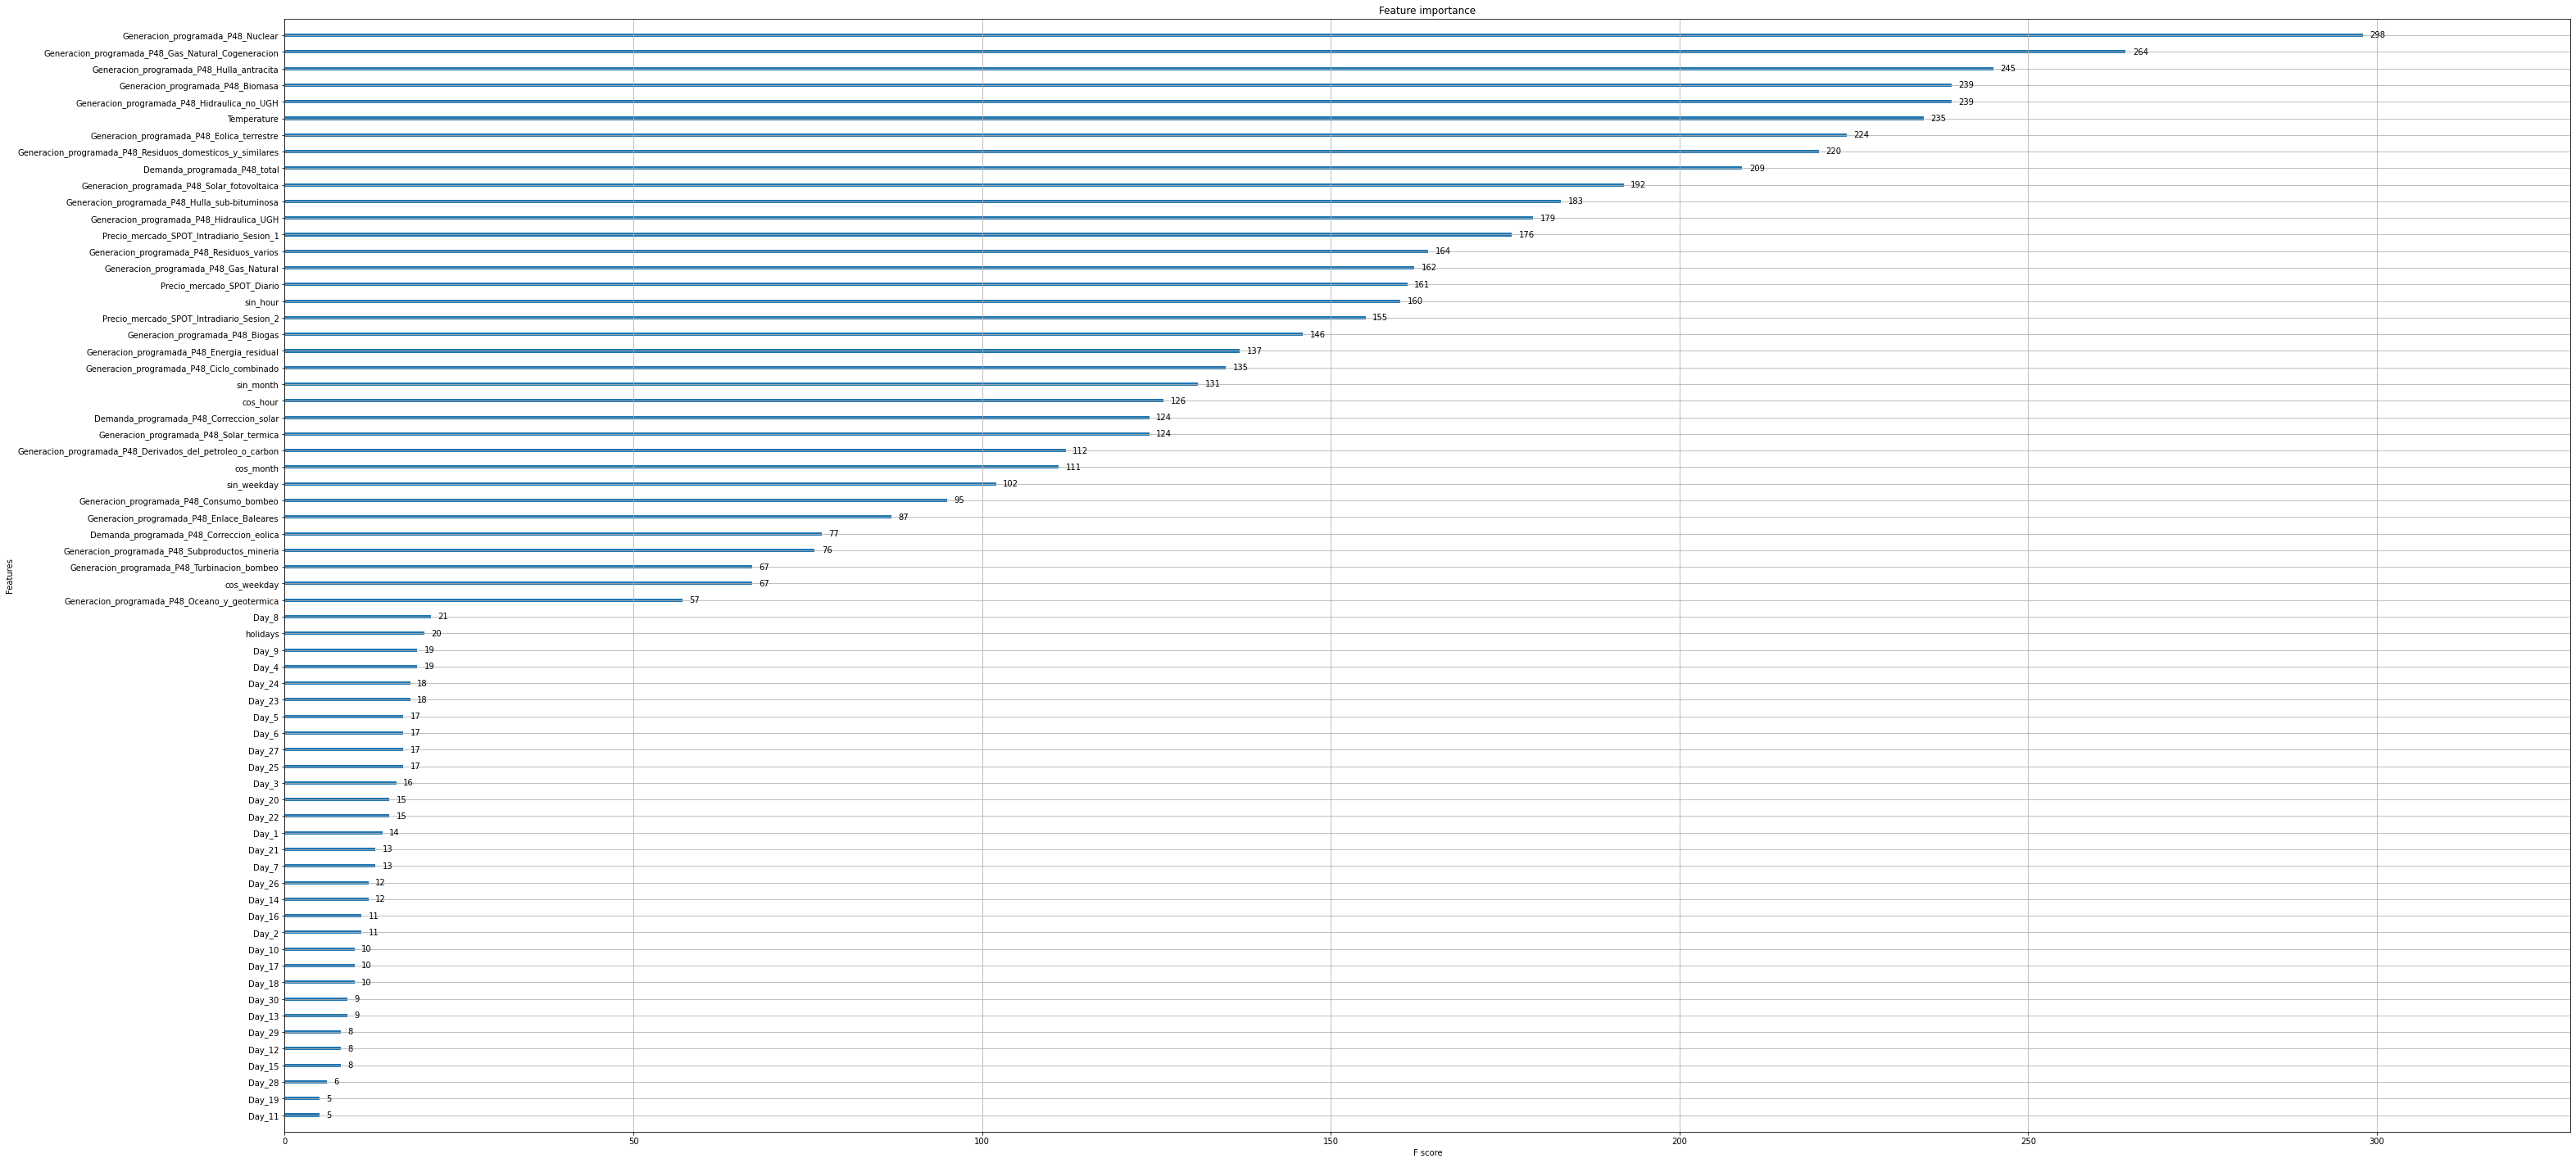

In [52]:
xgb.plot_importance(xgb_mod.best_estimator_)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [53]:
y_pred = xgb_mod.best_estimator_.predict(X_test) 

In [54]:
np.sqrt(mean_squared_error(y_test, y_pred))

14.648602573845885

In [55]:
r2_score(y_test,y_pred)

0.8345992915626569

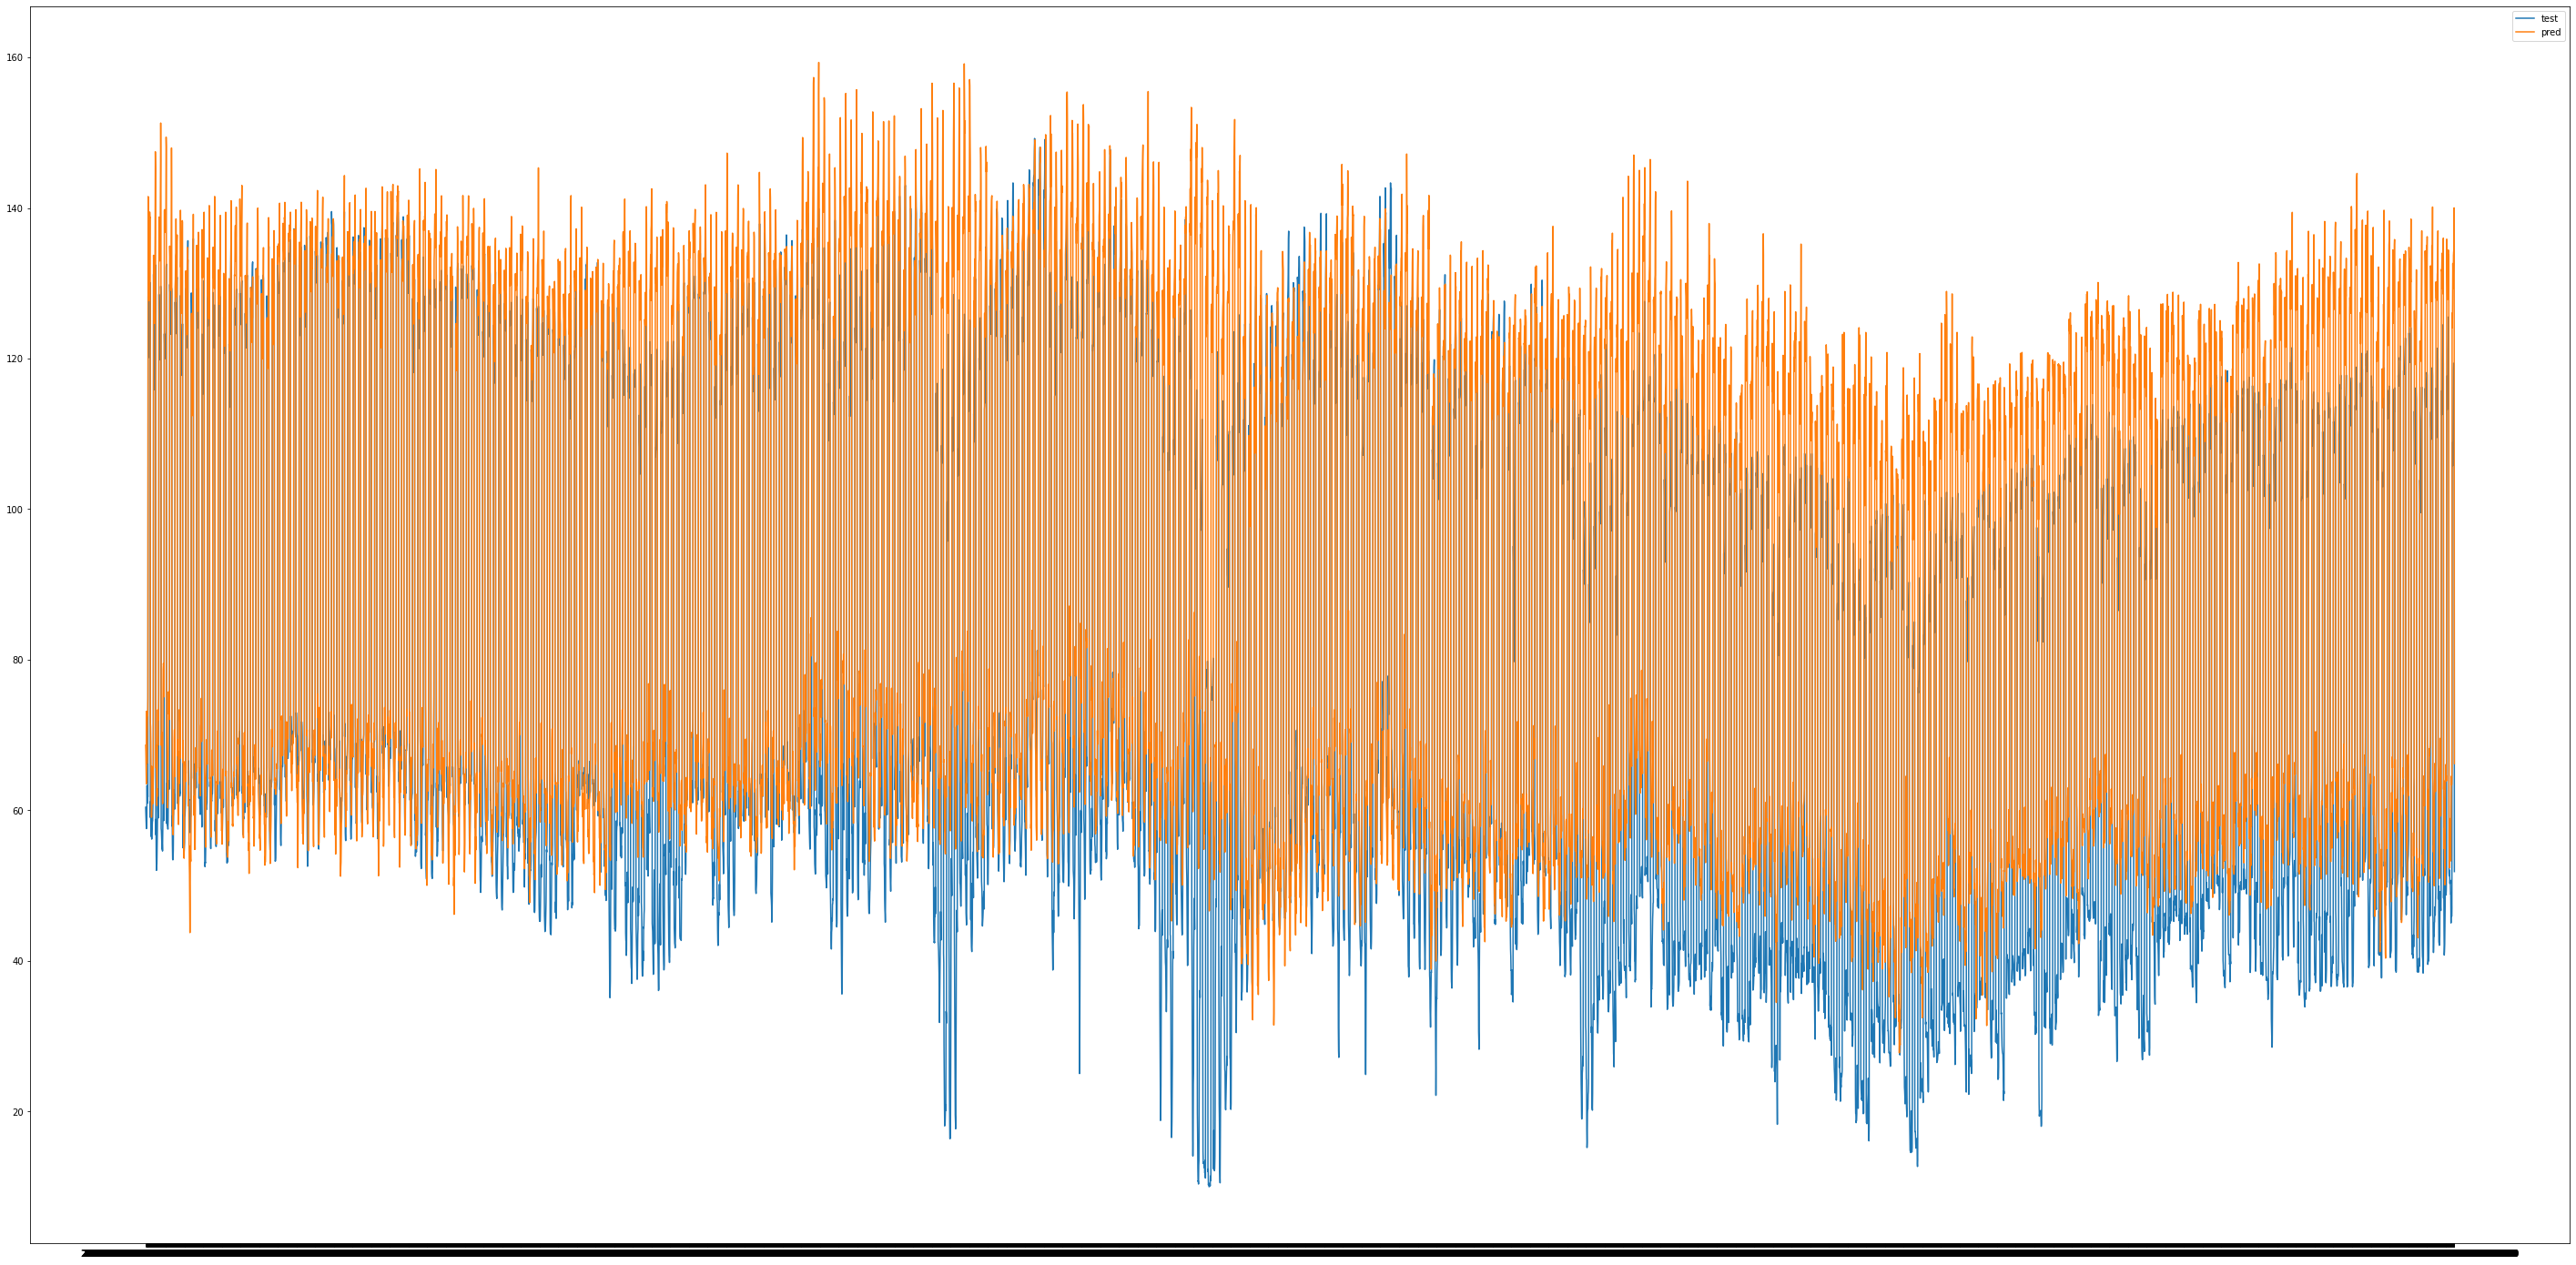

In [56]:
plt.rcParams['figure.figsize'] = [50, 25]
plt.plot(y_test, label='test')
plt.plot(y_pred, label='pred')
plt.legend()
plt.show()

In [57]:
pd.DataFrame({'y_test':y_test, 'y_pred':y_pred},index = y_test.index).to_csv('./../Visualization/Xgboost_time_series.csv')